# Comparing Confidence Sequences for IID Mean

Comparing CM-EB, Stitching EB, PM-EB, and Asymptotic CS for IID mean (of differences).

Generally speaking, the order of widths is expected to be (small to large): Asymptotic CS, CM-EB / PM-EB, Stitching EB, CM-H / PM-H, and Stitching H. (Hoeffding CS widths are omitted as they are substantially larger than the rest.)

In [1]:
import os.path
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

import comparecast as cc

In [2]:
cc.set_theme()

In [3]:
os.makedirs("plots/iid_mean", exist_ok=True)

# savefig_ext, savefig_dpi = "svg", 300
# savefig_ext, savefig_dpi = "eps", 300
savefig_ext, savefig_dpi = "pdf", 300

## Data: Simulated IID Differences between Betas

For $i = 1, 2, \dotsc, 10,000$:
$$
\hat\delta_i \overset{IID}{\sim} \mathrm{Beta}(30, 10) - \mathrm{Beta}(10, 30)
$$

Note that $-1 \leq \hat\delta_i \leq 1$ a.s., and $\mathbb{E}[\hat\delta_i] = \frac{30}{30+10} - \frac{10}{10+30} = \frac{1}{2}$.

In [4]:
# setup
alpha = 0.05

# data: Beta(a, b) - Beta(b, a)
a, b = 30, 10  # beta hyperparameters
rng = np.random.default_rng(1)
T = 10000
lo, hi = -1., 1.
xs = rng.beta(a, b, size=T) - rng.beta(b, a, size=T)

# Sample mean (centers)
ts = np.arange(1, len(xs) + 1)
sums = np.cumsum(xs)
mus = sums / ts

# Sample variance (estimate of intrinsic time)
shifted_mus = mus.copy()
shifted_mus[1:], shifted_mus[0] = mus[:-1], mus[0]
vs = np.maximum(1., np.cumsum((xs - shifted_mus) ** 2))

In [5]:
# Build data: S_t and V_t
df = pd.DataFrame({
    "t": ts,
    "x": xs,
    "s": sums,
    "v": vs,
})

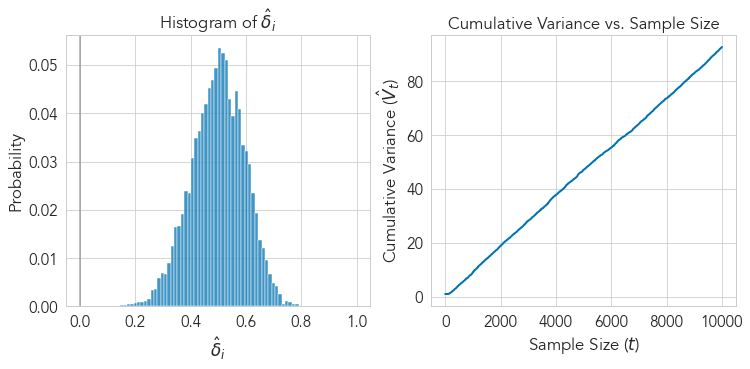

In [6]:
# double plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5), facecolor="white")
sns.histplot(x="x", stat="probability", data=df, ax=ax[0])
ax[0].set(
    xlim=(-0.05, 1.05),
    xlabel=r"$\hat\delta_i$",
    title=r"Histogram of $\hat\delta_i$",
)
ax[0].axvline(x=0, linewidth=2, alpha=0.5, color="gray")
sns.lineplot(x="t", y="v", linewidth=2, data=df, ax=ax[1])
ax[1].set(
    #xscale="log",
    #xlim=(10**1, 10**4),
    #yscale="log",
    xlabel=r"Sample Size ($t$)",
    ylabel=r"Cumulative Variance ($\hat{V}_t$)",
    title=r"Cumulative Variance vs. Sample Size",
)

# fig.suptitle(r"$\delta_i \overset{iid}{\sim} \mathrm{Beta}(%d, %d) - \mathrm{Beta}(%d, %d)$" % (a, b, b, a))
# fig.subplots_adjust(top=0.8, wspace=0.25)

fig.savefig(f"plots/iid_mean/data_with_vs.{savefig_ext}", dpi=savefig_dpi)
None

## Comparing Uniform Boundaries for Empirical Bernstein CS

Given that $\hat{V}_t$ ranges up to $10^3$, we test $v_\mathrm{opt} \in \{0.1, 1, 10, 100, 1000\}$.

In [7]:
df_rows = []

# CM-EB for v_opt = 0.1, 1, 10, 100, 10000
for log_v in [-1, 0, 1, 2, 3]:
    v = 10 ** log_v
    lcbs, ucbs = cc.confseq_eb(xs, alpha, lo, hi, 
                               boundary_type="mixture", v_opt=v)
    df_rows.extend([
        {
            "Sample Size": t, 
            r"$\hat{V}_t$": v_t,
            "Boundary": "ConjMix",
            r"$v_{{opt}}$": v,
            "Width": ucb - lcb,
        }
        for t, (v_t, lcb, ucb) in enumerate(zip(vs, lcbs, ucbs), 1)
    ])


df0 = pd.DataFrame(df_rows)
df0

,Sample Size,$\hat{V}_t$,Boundary,$v_{{opt}}$,Width
0,1,1.000000,ConjMix,0.1,33.891182
1,2,1.000000,ConjMix,0.1,16.945591
2,3,1.000000,ConjMix,0.1,11.297061
3,4,1.000000,ConjMix,0.1,8.472795
4,5,1.000000,ConjMix,0.1,6.778236
...,...,...,...,...,...
49995,9996,92.738264,ConjMix,1000.0,0.008547
49996,9997,92.739428,ConjMix,1000.0,0.008546
49997,9998,92.761421,ConjMix,1000.0,0.008545
49998,9999,92.762037,ConjMix,1000.0,0.008545


In [8]:
# PM-EB, Stitch-EB, AsympCS
s, eta = 1.4, 2
v_opt = 10.

# (cs_type, boundary_type, param_name, param_value, CS)
confseqs = [
    ("ConjMix-EB", "$v_{{opt}}$", v_opt,
     cc.confseq_eb(xs, alpha, lo, hi, boundary_type="mixture", v_opt=v_opt)),
    ("Stitching-EB", "$v_{{opt}}$", v_opt,
     cc.confseq_eb(xs, alpha, lo, hi, boundary_type="stitching", v_min=v_opt)),
    ("PredMix-EB", "$c$", 0.5,
     cc.confseq_pm_eb(xs, alpha, c=0.5, lo=lo, hi=hi)),
    ("Asymptotic", "$t^*$", v_opt,
     cc.confseq_asymptotic(xs, alpha, t_star=v_opt, assume_iid=True)),
]

df_rows = []
for cs_type, param_name, param_value, (lcbs, ucbs) in confseqs:
    df_rows.extend([
        {
            "Sample Size": t,
            "CS Type": cs_type,
            "LCB": lcb,
            "UCB": ucb,
            "Width": ucb - lcb,
        }
        for t, (lcb, ucb) in enumerate(zip(lcbs, ucbs), 1)
    ])

df1 = pd.DataFrame(df_rows)
df1

,Sample Size,CS Type,LCB,UCB,Width
0,1,ConjMix-EB,-9.530629,10.641921,20.172551
1,2,ConjMix-EB,-4.467727,5.618548,10.086275
2,3,ConjMix-EB,-2.792559,3.931625,6.724184
3,4,ConjMix-EB,-1.980301,3.062837,5.043138
4,5,ConjMix-EB,-1.476655,2.557855,4.034510
...,...,...,...,...,...
39995,9996,Asymptotic,0.495255,0.502723,0.007468
39996,9997,Asymptotic,0.495252,0.502719,0.007467
39997,9998,Asymptotic,0.495237,0.502704,0.007467
39998,9999,Asymptotic,0.495235,0.502702,0.007467


### Black-and-white compatible version

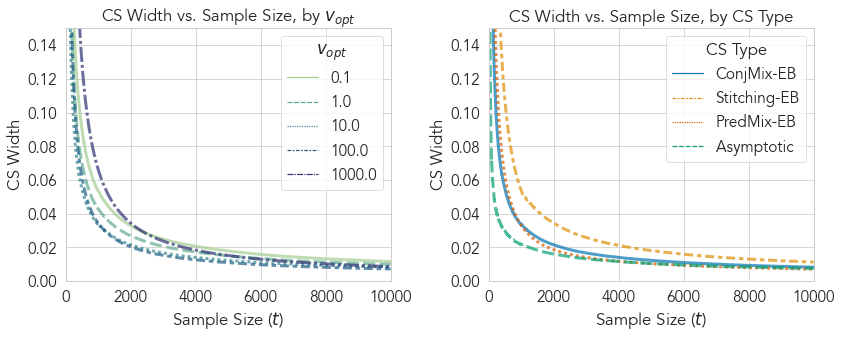

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (a) comparison among v_opt values for CM
sns.lineplot(
    x="Sample Size",
    y="Width",
    hue=r"$v_{{opt}}$", 
    hue_norm=matplotlib.colors.LogNorm(),
    style=r"$v_{{opt}}$",
    palette="crest",
    alpha=0.7,
    linewidth=3,
    data=df0,
    ax=axes[0],
)
axes[0].set(
    title=r"CS Width vs. Sample Size, by $v_{{opt}}$",
    # xscale="log",
    # xlim=(10**1, 10**4),
    xlabel=r"Sample Size ($t$)",
    ylabel="CS Width",
    xlim=(0, 10000),
    ylim=(0.0, 0.15),
)

# (b) comparison of CM-EB, PM-EB, Stitch-EB, AsympCS; v_opt=10
sns.lineplot(
    x="Sample Size",
    y="Width",
    hue="CS Type",
    palette=[cc.get_color_by_index(i) for i in [0, 1, 3, 2]],
    style="CS Type",
    style_order=["ConjMix-EB", "Asymptotic", "PredMix-EB", "Stitching-EB"],
    alpha=0.7,
    linewidth=3,
    data=df1,
    ax=axes[1],
)
axes[1].set(
    title=r"CS Width vs. Sample Size, by CS Type",
    # xscale="log",
    # xlim=(10**1, 10**4),
    xlabel=r"Sample Size ($t$)",
    ylabel="CS Width",
    xlim=(0, 10000),
    ylim=(0.0, 0.15),
)

#fig.suptitle(f"Width of {100-100*alpha:g}% EB CS for Beta({a}, {b}) - Beta({b}, {a})")
fig.tight_layout()
fig.savefig(f"plots/iid_mean/boundary_comparison.{savefig_ext}", dpi=savefig_dpi)
None